# Simple Housing Model - Gradient Boosted Regression

The task is to implement a simple model to predict home prices for a small real estate transactions dataset.

Predict the close price as of list date given the other attributes.
Determine effectiveness with and without ListPrice.
Add features as necessary.

## Outline
<a href='#section1'>1. Load Libraries and Data</a>  
<a href='#section2'>2. Preprocessing - Data Cleaning</a>  
<a href='#section3'>3. Preprocessing - Feature Engineering</a>  
<a href='#section4'>4. Preprocessing - Convert Categorical to Dummy Vectors</a>  
<a href='#section5'>5. Analysis - Data Set Creation</a>  
<a href='#section6'>6. Analysis - Recursive Feature Elimination</a>  
<a href='#section7'>7. Regression Model - Gradient Boosting Regression</a>  
<a href='#section8'>8. Regression Performance</a>  
<a href='#section9'>9. What is Next?</a>

<a id='section1'></a>
## Load Libraries and Data

In [1]:
import sys
for x in sys.path: 
    print(x)


/Users/wschram/anaconda/bin/python3
//anaconda/envs/py35/lib/python35.zip
//anaconda/envs/py35/lib/python3.5
//anaconda/envs/py35/lib/python3.5/plat-darwin
//anaconda/envs/py35/lib/python3.5/lib-dynload
/anaconda/envs/py35/lib/python3.5/site-packages/setuptools-21.2.1-py3.5.egg
//anaconda/envs/py35/lib/python3.5/site-packages
//anaconda/envs/py35/lib/python3.5/site-packages/IPython/extensions
/Users/wschram/.ipython


In [2]:
import os
import time
import math
import re

import numpy as np
import pandas as pd
import datetime as dt
import statistics as stat
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import cross_validation
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

## Classification Specific:
#from sklearn.metrics import classification_report
#from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
#                             f1_score)

In [13]:
## Load Data Set
df = pd.read_csv('data_sci_snippet.csv')
df.head(1)

,ListingId,LivingArea,NumBedrooms,NumBaths,Pool,ExteriorStories,ListDate,ListPrice,GeoLat,GeoLon,PublicRemarks,CloseDate,ClosePrice,ListingStatus,DwellingType
0,5077399,3054.0,4,2.5,Private,1.0,2014-03-04,675000.0,33.593239,-111.961056,This property OUTSTANDING offers outdoor livin...,NaN,NaN,Cancelled,Single Family - Detached


<a id='section2'></a>
## Preprocessing

### Data Cleaning

In [28]:
## Remove or Impute Missing Data
## If count(NaN) << 1% of Data: drop row
## Else impute with median values or Multiple-Imputations
#print('Number of rows containing data:\n', df.count(), sep='')
#print('Number of rows with missing data:\n', df.isnull().sum(), sep='')
print('Percent missing data:\n', sep='')
print(df.isnull().sum()/df.count().max()*100)

Percent missing data:

ListingId           0.000000
LivingArea          0.365014
NumBedrooms         0.000000
NumBaths            0.000000
Pool                0.000000
ExteriorStories     0.000000
ListDate            0.000000
ListPrice           0.000000
GeoLat              0.172902
GeoLon              0.172902
PublicRemarks       0.995494
CloseDate          33.748996
ClosePrice         33.748996
ListingStatus       0.000000
DwellingType        0.000000
dtype: float64


In [29]:
## Drop or Impute: Living Area:
## If None, replace with median value, ideally from Zip or town 
# Drop
#df = df[df.LivingArea.notnull()]
#-OR-
# Impute
df['LivingArea'].fillna(df['LivingArea'].mean(), inplace=True)  #.mean / .median / knn(which isn't implemented)
#df['LivingArea'].fillna(df.groupby('ZipCode')['LivingArea'].transform('median'), inplace=True) #Save for Zip code gorouping

# Test
#df[df['ListingId'] == 5140687]  # Confirm NaN replaced with median
#df.isnull().sum()

In [30]:
## Drop or Impute: GeoLat/GeoLon
## This data might be in the 'PublicRemark'
# Drop
#df = df[df.GeoLat.notnull()]
#df = df[df.GeoLon.notnull()]
#-OR-
# Impute
df['GeoLat'].fillna(df['GeoLat'].mean(), inplace=True)  #.mean or .median
df['GeoLon'].fillna(df['GeoLon'].mean(), inplace=True)  #.mean or .median
#df['LivingArea'].fillna(df.groupby('ZipCode')['LivingArea'].transform('median'), inplace=True) #Save for Zip code grouping
#df['LivingArea'].fillna(df.groupby('ZipCode')['LivingArea'].transform('median'), inplace=True) #Save for Zip code grouping

# Test
#df.isnull().sum()

In [31]:
## PublicRemarks: Replace Null with placeholder ' '
df['PublicRemarks'].fillna(' ', inplace=True)

## Lower Case PublicRemarks (00m:07s)
df['PublicRemarks'] = df['PublicRemarks'].apply(lambda x : re.sub(r'[\b\(\)\\\"\'\/\[\]\s+\,\.:\?!;#~*=+-_]', ' ', x))
df['PublicRemarks'] = df['PublicRemarks'].apply(lambda x : re.sub( '\s+', ' ', x).strip() )  # remove white space
df['PublicRemarks'] = df['PublicRemarks'].apply(lambda x : x.lower())

# Test
#df[df.PublicRemarks.isnull()]  # If it works the output has zero rows.

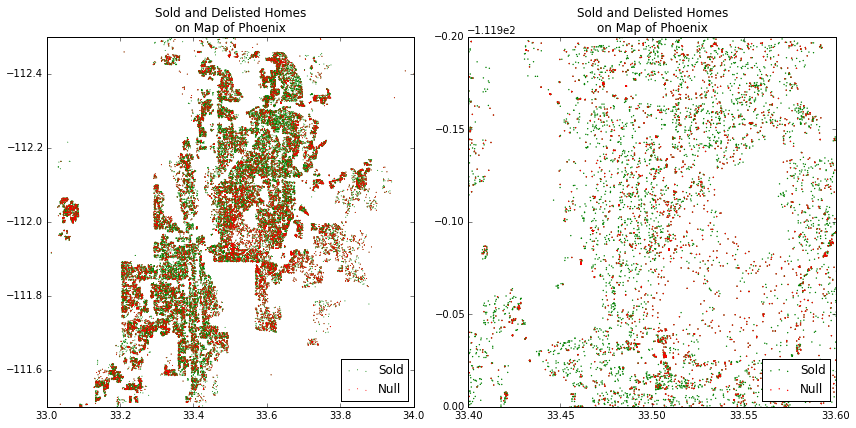

In [32]:
## Test ClosePrice: Verify unbiased null data

ClosePriceNull = df[df.ClosePrice.isnull()]
#ClosePriceNull.head(1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.xlim(33,34)
plt.ylim(-111.5,-112.5)
plt.scatter(df['GeoLat'], df['GeoLon'], s=1, c='g', edgecolor='none', label='Sold')
plt.scatter(ClosePriceNull['GeoLat'], ClosePriceNull['GeoLon'], s=1, c='r', edgecolor='none', label='Null')
plt.title('Sold and Delisted Homes\non Map of Phoenix')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.xlim(33.4,33.6)
plt.ylim(-111.9,-112.1)
plt.scatter(df['GeoLat'], df['GeoLon'], s=2, c='g', edgecolor='none', label='Sold')
plt.scatter(ClosePriceNull['GeoLat'], ClosePriceNull['GeoLon'], s=2, c='r', edgecolor='none', label='Null')
plt.title('Sold and Delisted Homes\non Map of Phoenix')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [33]:
## ClosePrice:  <--Last pre-processing step!
## Exclude Null ClosePrice Data, because it doesn't inform the ML algo
df = df[df.ClosePrice.notnull()].reset_index(drop=True)
# Removes are rows with no ClosePrice and resets index

In [34]:
## Confirm Dataset Cleaned!
print(df.shape)
print('Percent missing data:\n', sep='')
df.isnull().sum()

(37934, 15)
Percent missing data:



ListingId          0
LivingArea         0
NumBedrooms        0
NumBaths           0
Pool               0
ExteriorStories    0
ListDate           0
ListPrice          0
GeoLat             0
GeoLon             0
PublicRemarks      0
CloseDate          0
ClosePrice         0
ListingStatus      0
DwellingType       0
dtype: int64

### Filter Outliers
#### These are assumptions, which may be challenged over time as business model changes.

In [37]:
## Remove Baths Greater than 10, why b/c these are probably McMansions and Condo-complexes
df = df[df.NumBaths<=10].reset_index(drop=True)

In [43]:
## Remove listings over 1 Million, Since algo is focused on $200-500k properties.
#df[df.ClosePrice>500000].sort(['ClosePrice','ListingId'], ascending=[0, 1])
df = df[df.ClosePrice<=1000000].reset_index(drop=True)

In [44]:
df.describe()

,ListingId,LivingArea,NumBedrooms,NumBaths,ExteriorStories,ListPrice,GeoLat,GeoLon,ClosePrice
count,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000
mean,5120518.629353,1910.179051,3.230906,2.225845,1.335266,234750.289192,33.490748,-112.001418,228583.102392
std,25405.520494,750.295737,0.904067,0.599427,0.796535,142989.467161,0.245409,0.293840,137755.224547
min,5077408.000000,0.000000,0.000000,0.000000,1.000000,8500.000000,31.444146,-114.680805,1.000000
25%,5098414.500000,1397.000000,3.000000,2.000000,1.000000,143900.000000,33.362858,-112.206922,140000.000000
50%,5119911.000000,1756.000000,3.000000,2.000000,1.000000,199000.000000,33.480376,-112.010082,194500.000000
75%,5142504.000000,2254.000000,4.000000,2.500000,2.000000,285000.000000,33.616682,-111.804504,279000.000000
max,5178286.000000,8822.000000,8.000000,8.000000,23.000000,1220000.000000,36.775648,-109.092285,1000000.000000


<a id='section3'></a>
### Feature Engineering

In [45]:
## Convert Dates: str to Datetime
df['ListDate'] = pd.to_datetime(df['ListDate'])
df['CloseDate'] = pd.to_datetime(df['CloseDate'])
## Convert Dates: datetime to ordinals
df['CloseDateInt'] = df['CloseDate'].apply(lambda x: x.toordinal())
df['ListDateInt'] = df['ListDate'].apply(lambda x: x.toordinal())

In [46]:
## Add TimeToClose  # Hypothesis: As time to close -> increases, ClosePrice decreases
df['TimeToClose'] = df['CloseDateInt'] - df['ListDateInt']

In [47]:
## Generate Postal Code
## Input: (Lat/Long/(zipcode/geoJSON)) -> output: Zip Code
#import sys  # Used to import method from file
#sys.path.insert(1,'/users/wschram/Documents/Github/Regression_Challenge')

import json
import geojson

## Load Data Set
zips = pd.read_csv('zips.csv')
zips['polygon'] = zips['geojson'].apply(lambda x : list(geojson.utils.coords(json.loads(x))))

# Force Lat and Lon to float
zips['Lat'] = np.nan  #.astype(float)
zips['Lon'] = np.nan  #.astype(float)
# Use mean of path as Centroid proxy
zips['Lat'] = zips['polygon'].apply(lambda x : np.mean([pair[1] for pair in x ])) #<-doesn't work!
zips['Lon'] = zips['polygon'].apply(lambda x : np.mean([pair[0] for pair in x ]))

## Method: Ray Casting
def point_in_poly(x, y, poly):

    n = len(poly)
    inside = False

    p1x,p1y = poly[0]
    for i in range(n+1):
        p2x,p2y = poly[i % n]
        if y > min(p1y,p2y):
            if y <= max(p1y,p2y):
                if x <= max(p1x,p2x):
                    if p1y != p2y:
                        xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x,p1y = p2x,p2y
        
    return inside


## Convert Lat/Lon, via a GeoJSON polygon, to Postal Code
def coord_in_zip(Lat, Lon, zips):
    # sort zips by Lat, and in the future Lon
    df2 = zips.ix[((zips.Lat-Lat)+(zips.Lon-Lon)).abs().argsort()].reset_index(drop=True) # [:20] , after argsort()
    #df2 = zips.ix[(zips.Lat-Lat).abs().argsort()[:8]].reset_index(drop=True)  # OLD: 1-axis version
    # Test Lat/Lon against zipcode geoJSON, return Postal Code
    for row in range(len(df2)):
        if point_in_poly(Lon, Lat, df2['polygon'].loc[row]) == True:
            return df2['postal_code'].loc[row]
        else:
            pass

In [48]:
## Postal Code Array (00h43m47s)
start_time = time.time()

df['PostalCode'] = np.nan
for i in range(0, len(df)):
    if pd.isnull(df['PostalCode'][i]) == True:
        df.loc[i,'PostalCode'] = coord_in_zip(df['GeoLat'][i], df['GeoLon'][i], zips)  # Replaced: df['PostalCode'][i]
    else: pass

stop_time = time.time()
print("Computation time: %.2fs" % (stop_time - start_time))
os.system('say "Computation complete!"');


## Debug
#print(df['GeoLat'][4],df['GeoLon'][4])
#print( df.loc[12830:12860,'PostalCode'] )
#row = 508
#print(df['GeoLat'][row],df['GeoLon'][row])
#print( pd.isnull( df['PostalCode'][1] ) )

Computation time: 431.60s


0

In [49]:
## Summary
count = df['PostalCode'].isnull().sum()
print('Number of rows without a Postal Code\t:', count)  
print('Number of rows total\t\t\t:', len(df))

Number of rows without a Postal Code	: 876
Number of rows total			: 37591


In [54]:
## Add PostalCode with Web Queries
##    b/c long / lat doesn't define neighborhoods or school dist.
##    A dummy vector of the zip is better!
### --> DANGER: this code takes a long time to run! <--

from geopy.geocoders import Nominatim

geolocator = Nominatim()

for n in range(0,len(df)):   # len(df)  #0,len(df2) #100=35s  500=2m:41s
    try:
        if math.isnan(df.loc[n,'PostalCode']) == True:
            df.loc[n,'PostalCode'] = int(geolocator.reverse('{lat}, {long}'.format(lat=str(df.loc[n,'GeoLat']), long=str(df.loc[n,'GeoLon']))).raw['address']['postcode'])
        else: pass # Row already solved!
    except: 
        print(n, df.loc[n,'GeoLat'], df.loc[n,'GeoLon'], df.loc[n,'PostalCode'])


#import os; 
os.system('say "Postal code web queries complete!"');
#os.system('say beep');

## Debug Tools
#type( df.loc[37932,'PostalCode'] )
#df.loc[2511,]
#df.loc[11:500,['ZipCode']]
#df.loc[1600:1610,['GeoLat','GeoLon','ZipCode']]
#df['ZipCode'].value_counts()
#df['GeoLat'].value_counts()

236 34.635942 -111.129106 nan
357 33.321139 -112.960082 nan
1686 33.425869 -112.802593 nan
4195 34.35871 -111.529095 nan
4640 35.101757 -111.720889 nan
4724 34.375422 -110.481827 nan
5010 35.103135 -111.714605 nan
5011 35.103147 -111.714564 nan
5105 34.39453 -110.539842 nan
5369 32.809247 -111.634629 nan
5762 32.812633 -111.63054 nan
5952 35.102364 -111.710041 nan
9934 34.832997 -112.883001 nan
10361 34.083258 -109.958573 nan
10990 34.375422 -110.481827 nan
13068 34.956703 -111.488228 nan
13333 33.292445 -112.796889 nan
13486 34.083258 -109.958573 nan
13704 34.734138 -111.156226 nan
14666 32.784322 -111.523102 nan
15733 34.203563 -110.0757 nan
17242 35.234489 -112.221774 nan
18407 35.104423 -111.692472 nan
21038 34.375603 -110.481827 nan
21057 34.375603 -110.481827 nan
21262 35.097767 -111.711784 nan
21454 34.083258 -109.958573 nan
21928 34.669902 -111.087827 nan
22202 35.098359 -111.712188 nan
22745 34.101523 -110.109854 nan
25592 33.350265 -112.935255 nan
26760 34.083258 -109.958573 

0

In [55]:
## Summary
count = df['PostalCode'].isnull().sum()
print('Number of rows without a Postal Code\t:', count)  
print('Number of rows total\t\t\t:', len(df))

Number of rows without a Postal Code	: 49
Number of rows total			: 37591


In [57]:
## Change 'NaN' to '-1'
df['PostalCode'].fillna(-1, inplace=True)  

In [58]:
## CAUTION!!! Do not overwrite FeatureEngineering.csv 
## Save to .csv / .json / .txt
#df.to_csv('FeatureEngineering.csv')

In [60]:
## Read from .csv / .json / .txt
df = pd.read_csv('FeatureEngineering.csv')

#print( df.columns.tolist() )
df = df.drop(df.columns[0],axis=1)  #'Unnamed: 0',axis=1
df['PublicRemarks'].fillna(' ', inplace=True)  # Write to csv, removes ' ' cells

df.head(1)
#df.describe()

,ListingId,LivingArea,NumBedrooms,NumBaths,Pool,ExteriorStories,ListDate,ListPrice,GeoLat,GeoLon,PublicRemarks,CloseDate,ClosePrice,ListingStatus,DwellingType,CloseDateInt,ListDateInt,TimeToClose,PostalCode
0,5077408,2230,4,2,Private,1,2014-03-01,475000,33.650984,-111.963151,ery special home in popular rabian iews feels ...,2014-06-24,460000,Closed,Single Family - Detached,735408,735293,115,85254


<a id='section4'></a>  
### Preprocessing - Convert Categorical to Dummy Vectors
Here we address what information is obtained from postal code, pool type, and Dwelling type.  

In [7]:
## Convert Categorical vectors to dummy (1-hot encoded) binary vectors 
### --> Proven less effective than a 0-n encoding based on utility
###        or avg. valuation.

#def gen_dummies(dfColumn,columnName):
#    data = pd.DataFrame({columnName: dfColumn})
#    res = pd.get_dummies(data)
#    return res

## Generate Dummy Vectors
#poolDummies = gen_dummies(df['Pool'], 'Pool')  #list(df.columns.values)[4]
#dwellingTypeDummies = gen_dummies(df['DwellingType'], 'DwellingType')  #list(df.columns.values)[14]

## Concatenate with df
#df = pd.concat([df, poolDummies], axis=1, join_axes=[df.index])
#df = pd.concat([df, dwellingTypeDummies], axis=1, join_axes=[df.index])
#df.head(3)

In [61]:
## Convert Categorical Data to a 'hot-encoding'
# Note that the magnitude that will be assessed is based on the analyst's 
# belief in the relative utility of the option on ClosePrice.
# Effectively this turns the features from categorical to ordinal.
# Ex. X[:, 0] = LabelEncoder().fit_transform(X[:,0])

## First 'Pool' Data Set (0-3 Hot-encoding)
lePool = preprocessing.LabelEncoder()
#lePool.fit(df['Pool'])
lePool.classes_ = ['None', 
                   'Community',
                   'Private', 
                   'Both Private & Community'] # Question this assumption!
#list(lePool.classes_)
df['PoolOrd'] = np.empty(len(df), dtype=int)
df['PoolOrd'] = lePool.transform(df['Pool'])
#df.head(1)

In [62]:
## Second DwellingType (0-7 Hot-encoding)
# Rank was determined by assessing the mean ClosePrice of the
# respective DwellingType.
leDT = preprocessing.LabelEncoder()
#leDT.fit(df['DwellingType'])
leDT.classes_ = ['Modular/Pre-Fab',
                 'Mfg/Mobile Housing',
                 'Gemini/Twin Home',
                 'Apartment Style/Flat',
                 'Loft Style',
                 'Townhouse',
                 'Patio Home',
                 'Single Family - Detached']
#list(leDT.classes_)
df['DwellingTypeOrd'] = np.empty(len(df), dtype=int)
df['DwellingTypeOrd'] = leDT.transform(df['DwellingType'])
df.head(1)

,ListingId,LivingArea,NumBedrooms,NumBaths,Pool,ExteriorStories,ListDate,ListPrice,GeoLat,GeoLon,...,CloseDate,ClosePrice,ListingStatus,DwellingType,CloseDateInt,ListDateInt,TimeToClose,PostalCode,PoolOrd,DwellingTypeOrd
0,5077408,2230,4,2,Private,1,2014-03-01,475000,33.650984,-111.963151,...,2014-06-24,460000,Closed,Single Family - Detached,735408,735293,115,85254,2,7


In [63]:
## Third PostalCode to Dummy (n-hot encoding)
## This is not necessary given the numeric nature of the attribute.
#lePC = preprocessing.LabelEncoder()
#lePC.fit(df['PostalCode'])
##list(lePC.classes_)
#df['PostalCodeOrd'] = np.empty(len(df), dtype=int)
#df['PostalCodeOrd'] = lePC.transform(df['PostalCode'])
#df.head(1)

In [64]:
## Deprecated with (n-hot encoding) ##

## Third PostalCode to Dummy (1-hot encoded) Binary Vectors
### --> Proven less effective than a 0-n encoding based on utility
###        or avg. valuation. But we'll start here.

## Reformat PostalCode to String
#df['PostalCode'] = df['PostalCode'].map('{:.0f}'.format)
#df['PostalCode'] = df['PostalCode'].astype('str') #.astype(int)
## Replace nan with -1
#df['PostalCode'] = df['PostalCode'].replace({'nan': -1})  

# Generate Dummy Vectors
#postalCodeDummies = pd.get_dummies(df['PostalCode'], prefix='Zip')  #list(df.columns.values)[20]
##print(postalCodeDummies)  

## Concatenate with df
#df = pd.concat([df, postalCodeDummies], axis=1, join_axes=[df.index])
##df.head(3)

In [65]:
## Create PublicRemarks n-gram vectors
## http://scikit-learn.org/stable/modules/feature_extraction.html
from sklearn.feature_extraction.text import CountVectorizer

corpus = df['PublicRemarks']

## Write a custom tokenizer and move df['PublicRemarks']
## formatting to this section!

# Noun Phrases in order of importance:
vocab = ['patio', 'fireplace', 'fans',
         'covered patio', 'car garage', 'bedroom bath',
         'breakfast bar', 'spa', 'vaulted ceiling', 
         'ceiling fans', 'walk in closet', 'move in ready', 
         'washer dryer', 'appliances', 'granite', 
         'trees',
         # Untested:
         'air conditioning', 'hot tub', 'hardwood',
         'fruit trees', 
# Care of Zillow (Cause the property to move faster, not necessarily alter value):
# Source: 
# http://www.marketwatch.com/story/using-thesekeywords-in-your-listing-could-sell-your-home-faster-2016-04-15
#         'barn door', 'shaker cabinet', 'farmhouse sink',
#         'subway tile', 'quartz', 'craftsman', 
#         'exposed brick', 'pendant light', 'frameless shower',
#         'heated floors', 'stainless steel', 'granite',
#         'backsplash', 'tankless water heater', 'outdoor kitchen',
        ]

## Bad indicators: 'HOA', 'garage', 'air condition',
##                 'fixer upper', 'tree', 'BBQ Grill', 
##                 'fire pit', 'BBQ', 'hardwood floor',
##                 'AC', 'hottub', 'new water heater',

vect = CountVectorizer(ngram_range=(1,4),  # (1,1) or (1,2)
                             lowercase=True,  # Convert to lowercase
                             token_pattern=r'\b\w+\b', # r'\b\[0-9]+|w+\b'
                             vocabulary = vocab,  # List of strings
                             max_features = 250,
                             min_df=2,  # at least n letters in gram
                            )

SparseMatrix = vect.fit_transform(corpus).toarray()
VectSparseMatrix = pd.DataFrame((vect.fit_transform(corpus).toarray()), 
                                columns=[vect.get_feature_names()])
# print(VectSparseMatrix)

#  TF-IDF  # This doesn't work try using the TF-IDF Vectorizer!!!
#from sklearn.feature_extraction.text import TfidfTransformer
#tfidf = TfidfTransformer(norm="l2")
#tfidf.fit(freq_term_matrix)
#VectSparseMatrix = TfidfTransformer(VectSparseMatrix)

#Experiement with .to_sparse() to remove zeros from df.
#PandasSparseMatrix  # Returns size of sparse matrix

In [66]:
## Debug: List PublicRemarks Attributes 
#df['PublicRemarks'][5]
#vectorizer.get_feature_names()
#PandasSparseMatrix.describe()
#VectSparseMatrix.shape
#PandasSparseMatrix.isnull().sum()

In [67]:
## Concatenate PublicRemark Attributes to dataframe
data = pd.concat([df, VectSparseMatrix], axis=1, join_axes=[df.index])
data = data.fillna(0)  # Catches NAs in dataset, found by RandomForest

## Test concat
print(data.shape)
#df.isnull().sum()

(37591, 41)


<a id='section5'></a>
## Analysis - Data Set Creation

In [68]:
## Generate Training and Test Data Set (X , y)
# Training Variables
X = data.drop(['ListDate',
               'PublicRemarks',  #May add n-grams to create booleans from this feature
               'CloseDate',
               'ClosePrice',
               'ListingStatus',
               'Pool',
               'DwellingType',], axis=1)  # 'PostalCode'
headers = X.dtypes.index

#X.shape
X.describe()

,ListingId,LivingArea,NumBedrooms,NumBaths,ExteriorStories,ListPrice,GeoLat,GeoLon,CloseDateInt,ListDateInt,...,walk in closet,move in ready,washer dryer,appliances,granite,trees,air conditioning,hot tub,hardwood,fruit trees
count,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,...,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000
mean,5120518.629353,1910.179051,3.230906,2.225845,1.335266,234750.289192,33.490748,-112.001418,735467.683807,735378.136628,...,0.138304,0.068793,0.025857,0.282488,0.238621,0.067144,0.002953,0.006996,0.020430,0.012370
std,25405.520494,750.295737,0.904067,0.599427,0.796535,142989.467161,0.245409,0.293840,77.768223,52.758998,...,0.353298,0.255927,0.159547,0.460209,0.482621,0.260074,0.054749,0.084619,0.146459,0.110772
min,5077408.000000,0.000000,0.000000,0.000000,1.000000,8500.000000,31.444146,-114.680805,735294.000000,735293.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5098414.500000,1397.000000,3.000000,2.000000,1.000000,143900.000000,33.362858,-112.206921,735409.000000,735332.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5119911.000000,1756.000000,3.000000,2.000000,1.000000,199000.000000,33.480376,-112.010082,735463.000000,735375.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5142504.000000,2254.000000,4.000000,2.500000,2.000000,285000.000000,33.616682,-111.804504,735514.000000,735423.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5178286.000000,8822.000000,8.000000,8.000000,23.000000,1220000.000000,36.775648,-109.092285,735688.000000,735476.000000,...,2.000000,2.000000,2.000000,3.000000,5.000000,4.000000,2.000000,2.000000,3.000000,2.000000


In [69]:
## Normalize Dataset (Vectors from 0-1)
X_norm = (X - X.min()) / (X.max() - X.min())

#X.shape
X_norm.describe()

,ListingId,LivingArea,NumBedrooms,NumBaths,ExteriorStories,ListPrice,GeoLat,GeoLon,CloseDateInt,ListDateInt,...,walk in closet,move in ready,washer dryer,appliances,granite,trees,air conditioning,hot tub,hardwood,fruit trees
count,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,...,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.000000,37591.00000,37591.000000
mean,0.427354,0.216524,0.403863,0.278231,0.015239,0.186752,0.383870,0.479445,0.440822,0.465227,...,0.069152,0.034397,0.012929,0.094163,0.047724,0.016786,0.001476,0.003498,0.00681,0.006185
std,0.251844,0.085048,0.113008,0.074928,0.036206,0.118027,0.046030,0.052579,0.197381,0.288301,...,0.176649,0.127964,0.079774,0.153403,0.096524,0.065018,0.027374,0.042310,0.04882,0.055386
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.208237,0.158354,0.375000,0.250000,0.000000,0.111762,0.359882,0.442672,0.291878,0.213115,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.421331,0.199048,0.375000,0.250000,0.000000,0.157243,0.381924,0.477895,0.428934,0.448087,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,0.645294,0.255498,0.500000,0.312500,0.045455,0.228229,0.407491,0.514680,0.558376,0.710383,...,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [70]:
# Prediction Variable
y = df['ClosePrice']
y.shape

(37591,)

<a id='section6'></a>
## Analysis - Recursive Feature Elimination

### Min(cv(MSE)) by eliminating feature variance

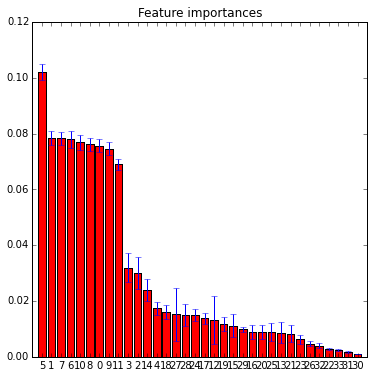

Feature ranking:
		Feature	Importance	Header
  	  1.	  5	(0.102014)	ListPrice
  	  2.	  1	(0.078322)	LivingArea
  	  3.	  7	(0.078291)	GeoLon
  	  4.	  6	(0.077915)	GeoLat
  	  5.	  10	(0.076870)	TimeToClose
  	  6.	  8	(0.076097)	CloseDateInt
  	  7.	  0	(0.075697)	ListingId
  	  8.	  9	(0.074584)	ListDateInt
  	  9.	  11	(0.068971)	PostalCode
  	  10.	  3	(0.031999)	NumBaths
  	  11.	  2	(0.030049)	NumBedrooms
  	  12.	  14	(0.023875)	patio
  	  13.	  4	(0.017424)	ExteriorStories
  	  14.	  18	(0.016088)	car garage
  	  15.	  27	(0.015239)	appliances
  	  16.	  28	(0.015025)	granite
  	  17.	  24	(0.014920)	walk in closet
  	  18.	  17	(0.013853)	covered patio
  	  19.	  12	(0.013263)	PoolOrd
  	  20.	  19	(0.011830)	bedroom bath
  	  21.	  15	(0.011142)	fireplace
  	  22.	  29	(0.009887)	trees
  	  23.	  16	(0.009016)	fans
  	  24.	  20	(0.008883)	breakfast bar
  	  25.	  25	(0.008785)	move in ready
  	  26.	  13	(0.008674)	DwellingTypeOrd
  	  27.	  21	(0.008197)	spa
  	  28.	  23	

0

In [71]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=10,  # 250 by default
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(6, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Print the feature ranking
print("Feature ranking:")
print("\t\tFeature\tImportance\tHeader")

for f in range(X.shape[1]):
    print("  \t  %d.\t  %d\t(%f)\t%s" % (f+1, indices[f], importances[indices[f]], headers[indices[f]]))

os.system("say 'Computation Complete!'")

In [19]:
## Wait Until Feature Reduction Calculation completes!!!
## Study showed re-running randomForest model reduced accuracy

## Drop features and see how mean-squared-error responds 
cutoff = 0.015  # Importance, 0.0015 = remove
cols = []
cols = [i for i in indices if importances[i] < cutoff]
if len(cols) == 0:
    pass
else: X = X.drop(X.columns[cols],axis=1)
headers = X.dtypes.index
print(cols)
cols = []

[11, 236, 232, 242, 237, 233, 253, 238, 240, 249, 243, 12, 244, 245, 250, 246, 239, 252, 70, 37, 30, 248, 251, 102, 82, 24, 99, 80, 130, 28, 115, 91, 92, 46, 156, 93, 84, 32, 159, 78, 98, 48, 44, 106, 161, 143, 81, 87, 49, 100, 29, 77, 22, 109, 157, 21, 116, 114, 55, 141, 97, 168, 31, 26, 23, 164, 33, 124, 121, 119, 88, 69, 155, 85, 86, 122, 35, 166, 160, 131, 101, 247, 83, 113, 18, 118, 53, 162, 54, 61, 142, 128, 51, 126, 43, 108, 76, 167, 58, 117, 16, 107, 171, 120, 65, 79, 67, 145, 34, 105, 134, 50, 127, 125, 137, 68, 150, 103, 123, 17, 56, 42, 71, 104, 112, 57, 148, 110, 163, 13, 41, 151, 153, 20, 47, 59, 136, 52, 45, 25, 40, 191, 129, 208, 14, 63, 165, 38, 36, 172, 139, 27, 199, 75, 194, 158, 15, 205, 149, 206, 147, 62, 193, 186, 204, 19, 135, 196, 73, 190, 64, 198, 169, 74, 111, 90, 211, 189, 138, 214, 39, 197, 209, 188, 95, 202, 144, 200, 210, 213, 175, 152, 220, 221, 216, 217, 212, 174, 66, 133, 222, 60, 203, 219, 96, 224, 89, 170, 146, 180, 140, 218, 173, 132, 223, 182, 215, 2

In [ ]:
## Repeat Feature Reduction? If not, continue. 

In [ ]:
## Debug
#headers
#X.head(1)

## Generate Validate / Test / Train Datasets

In [ ]:
## Divide set into 60/20/20 Train/Validation/Test sets 
## Use when comparing algorithms.
#X_train, X_intermediate, y_train, y_intermediate = cross_validation.train_test_split(X, y, train_size=0.6, test_size=0.4, random_state=0)
#X_validation, X_test, y_validation, y_test = cross_validation.train_test_split(X_intermediate, y_intermediate, train_size=0.5, test_size=0.5, random_state=0)

In [72]:
## Divide set into 66/33 (Train/Validation)/Test sets
## Use when comparing algorithms.
## In k-fold validation train and test data will interchange
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size=0.66, test_size=0.33, random_state=0)

<a id='section7'></a>
## Regression Model: Gradient Boosting Regression

In [1]:
## Hyperparameter Grid_Search for GBR
## https://www.youtube.com/watch?v=-5l3g91NZfQ
start_time = time.time()


from sklearn.grid_search import GridSearchCV

param_grid = {'learning_rate': [0.018], #  {0.1, 0.01, 0.001}
              'max_depth': [12],  #  {4, 6, 8, 10, 12} # Experts claim 4-6 is best! 10-12 is better?
              'n_estimators': [500],  #  {500, 1000} # More is Better!
              'min_samples_split': [4], #  {1, 5, 10} # More reduces bias from outliers
              'loss': ['huber']  # {'ls', 'lad', 'huber', 'quantile'}
              }

model = ensemble.GradientBoostingRegressor()
gs_cv = GridSearchCV(model, param_grid, scoring='mean_squared_error', n_jobs=4, verbose=2).fit(X_train, y_train)
# n_jobs = Number of jobs to run in parallel.

#Best hyperparameter setting
print('Best hyperparameters: %r' % gs_cv.best_params_)
#print('Best score: %.4f' % gs_cv.best_score_)

## Gradient Boosting Regression model
model = ensemble.GradientBoostingRegressor(**gs_cv.best_params_).fit(X_train, y_train)


stop_time = time.time();
print("Regressor ran in %.2fs" % (stop_time - start_time))
os.system("say 'Computation Complete!'")

NameError: name 'time' is not defined

In [76]:
## Compute Output Variables
# Mean Squared Error
mse = mean_squared_error(y_test, model.predict(X_test))
print("MSE: %.4f" % mse)

# CV(RMSD), coefficient of variation, st.dev/mean
cvrmsd = math.sqrt(mse)/np.mean(y)
print('Coefficient of Variation, CV(RMSD): %.4f' % cvrmsd)

# R^2 Score
r2 = r2_score(y_test, model.predict(X_test))
print("R^2 Score: %.4f" % r2)

# Plot the approximation
#plot_data()
#plt.plot(x_plot, model.predict(x_plot[:, np.newaxis]), color='r', linewidth=2)

MSE: 121658965.7847
Coefficient of Variation, CV(RMSD): 0.0483
R^2 Score: 0.9936


<a id='section8'></a>
## Regression Performance
### Entire dataset for training, no need for train/test/validation

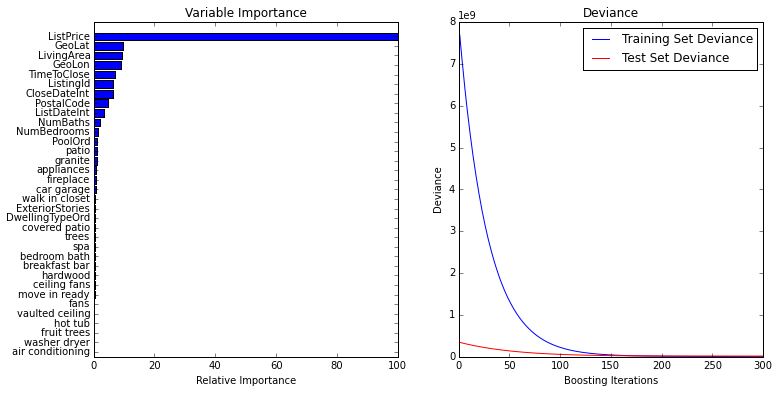

In [77]:
## Plot training deviance
# compute test set deviance
test_score = np.zeros((gs_cv.best_params_['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.title('Deviance')
plt.plot(np.arange(gs_cv.best_params_['n_estimators']) + 1, model.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(gs_cv.best_params_['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.xlim(0,300)

## Plot feature importance
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns.values[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

//anaconda/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


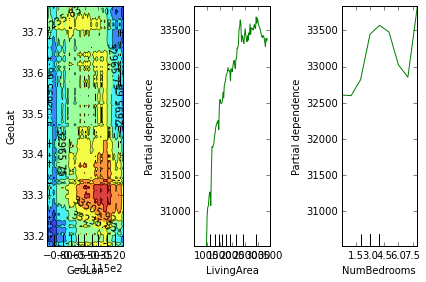

In [82]:
## Partial Dependency Plots

#X_train.columns
from sklearn.ensemble.partial_dependence import plot_partial_dependence

plt.figure()  # figsize=(30, 10)
#fig.set_size_inches(18.5, 10.5)

fig, axs = plot_partial_dependence(model, X_train,
                                   features = [[7,6], 1, 2],  #  [7,6] for 2.5D plot  1, 2, 3, 4, 5, 10, 11, 12, 13
                                   feature_names = X_train.columns,
                                   n_cols = 3)
fig.tight_layout()  # Or equivalently,  "plt.tight_layout()"
fig.show()

In [83]:
## Save Plots
fig.savefig('PartialDependence.pdf', bbox_inches='tight')  # .png
plt.close(fig) 

## Unfinished Analysis

In [99]:
predDf.head(3)
#predDf['GeoLon']
predDf = pd.DataFrame({'GeoLon': X_test['GeoLon'], 
                       'GeoLat': X_test['GeoLat']})
predDf.head(3)

,GeoLat,GeoLon
32187,33.475216,-112.058758
27306,33.017738,-111.390735
25681,33.717184,-112.277810


TypeError: with_transform() missing 2 required positional arguments: 'x' and 'y'

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


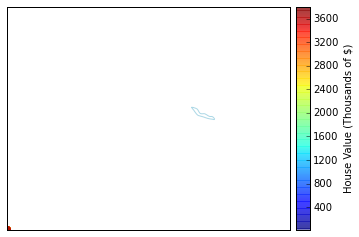

In [104]:
## Plot Housing Price on Map
## http://www.tonicebrian.com/2012/11/05/training-gradient-boosting-trees-with-python/

from mpl_toolkits.basemap import Basemap
#predDf = pd.DataFrame(X_test.copy())
predDf = pd.DataFrame({'GeoLon': X_test['GeoLon'], 
                       'GeoLat': X_test['GeoLat']})
predDf['y_pred'] = model.predict(X_test)

def arizona_map(ax=None, lllat=32.5, urlat=34.8, lllon=-113.5, urlon=-110):
    m = Basemap(ax=ax, projection='stere',
                lon_0=(urlon + lllon) / 2,
                lat_0=(urlat + lllat) / 2,
                llcrnrlat=lllat, urcrnrlat=urlat,
                llcrnrlon=lllon, urcrnrlon=urlon,
                resolution='f')
    #m.drawstates()
    #m.drawcountries()
    m.drawcoastlines(color='lightblue')
    return m

plt.figure()
m = arizona_map()
predDf = predDf.sort_values(by='y_pred') # Useful for plotting
#x,y = m(predDf['GeoLon'], predDf['GeoLat'])
x = predDf['GeoLon'] 
y = predDf['GeoLat']
serieA = (np.array(predDf['y_pred']) 
          - predDf['y_pred'].min())/(predDf['y_pred'].max()-predDf['y_pred'].min())
# z = plt.cm.jet(serieA)
z = np.array(predDf['y_pred'])/1000
m.scatter(x=x, y=y, c=z, s=60, alpha=0.5, edgecolors='none')
c = m.colorbar(location='right')
c.set_label("House Value (Thousands of $)")
m.plot()
plt.show()

In [65]:
### Doesn't work presently...!!! ###

## Plot Resulting Prediction vs. Test(Actual)
## Isn't necessary for Random Forests, save for test/train data challenges.

plt.figure(figsize=(6,6))

plt.scatter(y, model.oob_prediction_, color='blue', s=1, edgecolor='none')
plt.xlim(200000,500000)
plt.ylim(200000,500000)
plt.grid(True)
plt.ylabel('y_pred, ClosePrice Predicted [USD]')
plt.xlabel('y, ClosePrice Actual [USD]')
plt.title('Close Price Predicted vs. Actual')
plt.axes().set_aspect('equal') # 'datalim'
plt.show()

AttributeError: 'GradientBoostingRegressor' object has no attribute 'oob_prediction_'

In [ ]:
## Error Measurement: Variance between Prediction and Actual ClosePrice
## Isn't necessary for Random Forests, save for other algos.
#mean_squared_error(y_test, y_pred)

In [ ]:
## Debug Tools
#df.head(3)
#df['DwellingType'].head(20)
#df.describe()
#df.dtypes
#df.shape  #[1]
#df['LivingArea'] = df['LivingArea'].astype('float32')
#X.head(1)

<a id='section9'></a>
## What is Next?

After model is finalized, train on whole dataset. This isn't necessary with random forest unless a test set was created to compare to other machine learning algorithms.

-/ Next, try GBM (Gradient Boosted Machines) and GLM (Generalized Linear Model). GBM Normally beats deep learning and GLM (and random forest with optimization). Use Mean-squared-error to compare regression models.  
  
Apply a meta-learner specifically a GLM (nnps) to stack/ensemble the algorithms.

Create generalized Low-rank model (GLRM) and add to stack/ensemble, many classification algorithms are derived from the GLRM based on it's configuration.

-/ Study of 'PublicRemarks', n-gram collection and vectorization to account for additional variance in ClosePrice.


### Missing data:  
Source: http://artsci.wustl.edu/~gradconf/conf2015/Papers2015/1_3_Ho.pdf    
- Age of home, when was it built/refreshed?  
- % of neighbors with bachelors  
- % of neighbors with mastors/adv. degree  
- quality of neighborhood schools  
-/ fireplace  - can be found in the PublicRemarks  

### Requested features:
- Early stopping k-fold cross-validation